#input x, #truth y, #predict (y-x) in bins.

major changes:
- in Datagenerator(), add y=y-X[output_idxs]
- in create_predictions(): when unnormalizing, only multiply with std, dont add mean
- included adaptive bins

#Observations
- DOI takes much longer to train to same loss than normal categorical.
- not much better performance with adaptive bins

ToDo:
- change create_prediction() function for ensemble (not done) and binned (done) prediction. Currently x is added after predictions are made.
- better method to get adaptive bins. Currently bins are made on 1 year data
- unable to run compute_bin_crps() for full data. kernel dies. may load in chunks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *

In [3]:
tf.__version__

'2.2.0'

In [4]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
args = load_args('../nn_configs/B/81.1-resnet_d3_dr_0.1.yml')
args['train_years']=['2017', '2017']
args['valid_years']=['2018-01-01','2018-03-31']
args['test_years']=['2018-04-01','2018-12-31']
args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
args['datadir']='/home/garg/data/WeatherBench/5.625deg'
args['is_categorical']=True

In [7]:
args['is_doi']=True
args['bin_min']=-2; args['bin_max']=2 #checked min, max of (x-y) in train.
args['adaptive_bins']=None
args['num_bins'], args['bin_min'], args['bin_max']

(50, -2, 2)

In [8]:
args['filters'] = [128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 2*args['num_bins']]
#args['loss'] = 'lat_categorical_loss'

In [9]:
dg_train, dg_valid, dg_test = load_data(**args)

In [10]:
x,y=dg_train[0]; print(x.shape, y.shape)
x,y=dg_valid[0]; print(x.shape, y.shape) 
x,y=dg_test[0]; print(x.shape, y.shape)
#changing valid shape too. maybe not a good idea/not needed.

(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)


In [11]:
y.min(), y.max(), y[0,0,0,0,:]

(0.0,
 1.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

# Training

In [12]:
# model = build_resnet_categorical(
#     **args, input_shape=dg_train.shape,
# )
# # model.summary()

# categorical_loss = create_lat_categorical_loss(dg_train.data.lat, 2)
# model.compile(keras.optimizers.Adam(1e-3), loss=categorical_loss)
# model_history=model.fit(dg_train, epochs=50)


In [13]:
#training is slower compared to normal categorical without DOI

In [14]:
# #exp_id=args['exp_id']
# exp_id='categorical_doi_v1'
# model_save_dir=args['model_save_dir']

# model.save(f'{model_save_dir}/{exp_id}.h5')
# model.save_weights(f'{model_save_dir}/{exp_id}_weights.h5')

# #to_pickle(model_history.history, f'{model_save_dir}/{exp_id}_history.pkl')

In [15]:
# checking training

In [16]:
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Predictions

In [17]:
exp_id='categorical_doi_v1'
model_save_dir=args['model_save_dir']

In [18]:
#args['ext_mean'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
#args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')
#dg_test = load_data(**args, only_test=True)

In [19]:
model = keras.models.load_model(
    f'{model_save_dir}/{exp_id}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'categorical_loss': keras.losses.mse}
)

In [20]:
# #small test
# xtrue ,ytrue=dg_valid[0]
# ypred=model.predict(xtrue)
# print(ytrue.shape, ytrue.max(),ytrue.min(), ytrue.mean())
# print(ypred.shape, ypred.max(),ypred.min(), ypred.mean())
# print(xtrue[...,12].min(), xtrue[...,12].max(), xtrue[...,12].mean(), xtrue.shape)

In [21]:
#full-data (apr-dec 2018)
preds = create_predictions(model, dg_test, is_categorical=True, 
                           is_doi=True, adaptive_bins=None,
                           bin_min=args['bin_min'], bin_max=args['bin_max'])
preds
#maybe add bin_min, bin_max, is_doi,  to **kwargs in function.

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 3262)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 1.435127e-20 ... 7.340673e-27
    t        (time, lat, lon, bin) float32 4.620911e-29 ... 9.157175e-33

In [22]:
#extremely small values may increase numerical error? (x-y)
preds.t.min(), preds.t.max(), preds.t.mean()

(<xarray.DataArray 't' ()>
 array(0.),
 <xarray.DataArray 't' ()>
 array(0.85402346),
 <xarray.DataArray 't' ()>
 array(0.02000007, dtype=float32))

In [23]:
preds.t.bin_edges

array([-28.7634454 , -27.61290758, -26.46236977, -25.31183195,
       -24.16129413, -23.01075632, -21.8602185 , -20.70968069,
       -19.55914287, -18.40860505, -17.25806724, -16.10752942,
       -14.95699161, -13.80645379, -12.65591598, -11.50537816,
       -10.35484034,  -9.20430253,  -8.05376471,  -6.9032269 ,
        -5.75268908,  -4.60215126,  -3.45161345,  -2.30107563,
        -1.15053782,   0.        ,   1.15053782,   2.30107563,
         3.45161345,   4.60215126,   5.75268908,   6.9032269 ,
         8.05376471,   9.20430253,  10.35484034,  11.50537816,
        12.65591598,  13.80645379,  14.95699161,  16.10752942,
        17.25806724,  18.40860505,  19.55914287,  20.70968069,
        21.8602185 ,  23.01075632,  24.16129413,  25.31183195,
        26.46236977,  27.61290758,  28.7634454 ])

In [24]:
#attempt 1: add actual x values to prediction
#attempt 2: add unnormalized x (using mean, std of dg_test) -no need.

In [25]:
#attempt 1
datadir=args['datadir']
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [26]:
dg_test.lead_time

72

In [27]:
# valid_x=valid.sel(time=preds.time-np.timedelta64(3,'D'))
# valid_y=valid.sel(time=preds.time)

In [28]:
#Shifting left by 72 hours. Now this value can be added to preds.
valid_x_new=valid.shift(time=-dg_test.lead_time)
valid_x_new

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [29]:
print(
valid.t.isel(lat=0,lon=0).sel(time='2017-01-01T00:00:00').values,
valid.t.isel(lat=0,lon=0).sel(time='2017-01-04T00:00:00').values,
valid_x_new.t.isel(lat=0,lon=0).sel(time='2017-01-01T00:00:00').values)
#valid.t.isel(lat=0,lon=0,time=72).values,valid_x_new.t.isel(lat=0,lon=0,time=0).values

257.84134 258.57373 258.57373


# Most likely class

In [30]:
# Using bin_mid_points of prediction with highest probability
das = []
for var in ['z', 't']:
    idxs = np.argmax(preds[var], -1)
    most_likely = preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [preds.time, preds.lat, preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)

preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3262)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 -627.4 -627.4 -878.4 ... -125.5 -125.5
    t        (time, lat, lon) float64 7.478 7.478 6.328 ... -6.328 -7.478 -7.478

In [31]:
preds_ml_new=preds_ml+valid.shift(time=-dg_test.lead_time)

In [32]:
#be careful of last points (2018-12-28) to 2018-12-31. 
#they must contain nan values
preds_ml_new.t.isel(time=-36).values
#preds_new.t.sel(time='2018-12-28T22:00:00').values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [33]:
#removing last 3 days (naive approach)
preds_ml_new=preds_ml_new.sel(time=slice(None,'2018-12-28T22:00:00'))

In [34]:
preds_ml_new.t.max().values, preds_ml_new.t.min().values, preds_ml_new.t.mean().values

(array(330.08389793), array(207.84947847), array(275.43641178))

In [35]:
valid.t.max().values, valid.t.min().values, valid.t.mean().values

(array(311.45795, dtype=float32),
 array(218.9723, dtype=float32),
 array(275.03195, dtype=float32))

# RMSE

In [36]:
compute_weighted_rmse(preds_ml_new, valid).load()
#still very bad. for comparison, training on the same data for same epochs (loss=1.7) without difference to input method had rmse of 685 

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 1.165e+03
    t_rmse   float64 5.129

# Binned CRPS

In [37]:
preds['t'].mid_points

array([-28.18817649, -27.03763867, -25.88710086, -24.73656304,
       -23.58602523, -22.43548741, -21.28494959, -20.13441178,
       -18.98387396, -17.83333615, -16.68279833, -15.53226051,
       -14.3817227 , -13.23118488, -12.08064707, -10.93010925,
        -9.77957144,  -8.62903362,  -7.4784958 ,  -6.32795799,
        -5.17742017,  -4.02688236,  -2.87634454,  -1.72580672,
        -0.57526891,   0.57526891,   1.72580672,   2.87634454,
         4.02688236,   5.17742017,   6.32795799,   7.4784958 ,
         8.62903362,   9.77957144,  10.93010925,  12.08064707,
        13.23118488,  14.3817227 ,  15.53226051,  16.68279833,
        17.83333615,  18.98387396,  20.13441178,  21.28494959,
        22.43548741,  23.58602523,  24.73656304,  25.88710086,
        27.03763867,  28.18817649])

In [38]:
#changing Observation directly instead of predictions for binned crps
obs=valid-valid.shift(time=-dg_test.lead_time)
obs=obs.sel(time=preds.time) #reducing to preds size
obs=obs.sel(time=slice(None,'2018-12-28T22:00:00'))#removing nan values


In [39]:
print(
valid.t.isel(lat=0,lon=0).sel(time='2018-05-05T22:00:00').values,
valid_x_new.t.isel(lat=0,lon=0).sel(time='2018-05-05T22:00:00').values,
obs.t.isel(lat=0,lon=0).sel(time='2018-05-05T22:00:00').values
)

240.97852 246.35167 -5.3731537


In [40]:
obs #reduced set. 2018-01-04 to 2018-12-28

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3226)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-28T22:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(3226, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(3226, 32, 64), meta=np.ndarray>

In [41]:
def compute_bin_crps(obs, preds, bin_edges):
    """
    Last axis must be bin axis
    obs: [...]
    preds: [..., n_bins]
    """
    obs = obs.values
    preds = preds.values
    # Convert observation
    a = np.minimum(bin_edges[1:], obs[..., None])
    b = bin_edges[:-1] * (bin_edges[0:-1] > obs[..., None])
    y = np.maximum(a, b)
    # Convert predictions to cumulative predictions with a zero at the beginning
    cum_preds = np.cumsum(preds, -1)
    cum_preds_zero = np.concatenate([np.zeros((*cum_preds.shape[:-1], 1)), cum_preds], -1)
    xmin = bin_edges[..., :-1]
    xmax = bin_edges[..., 1:]
    lmass = cum_preds_zero[..., :-1]
    umass = 1 - cum_preds_zero[..., 1:]
#     y = np.atleast_1d(y)
#     xmin, xmax = np.atleast_1d(xmin), np.atleast_1d(xmax)
#     lmass, lmass = np.atleast_1d(lmass), np.atleast_1d(lmass)
    scale = xmax - xmin
#     print('scale =', scale)
    y_scale = (y - xmin) / scale
#     print('y_scale = ', y_scale)
    
    z = y_scale.copy()
    z[z < 0] = 0
    z[z > 1] = 1
#     print('z =', z)
    a = 1 - (lmass + umass)
#     print('a =', a)
    crps = (
        np.abs(y_scale - z) + z**2 * a - z * (1 - 2*lmass) + 
        a**2 / 3 + (1 - lmass) * umass
    )
    return np.sum(scale * crps, -1)

In [42]:
def compute_weighted_bin_crps(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    """
    t = np.intersect1d(da_fc.time, da_true.time)
    da_fc, da_true = da_fc.sel(time=t), da_true.sel(time=t)
    weights_lat = np.cos(np.deg2rad(da_true.lat))
    weights_lat /= weights_lat.mean()
    dims = ['time', 'lat', 'lon']
    if type(da_true) is xr.Dataset:
        das = []
        for var in da_true:
            result = compute_bin_crps(da_true[var], da_fc[var], da_fc[var].bin_edges)
            das.append(xr.DataArray(
                result, dims=dims, coords=dict(da_true.coords), name=var
            ))
        crps = xr.merge(das)
    else:
        result = compute_bin_crps(da_true, da_fc, da_fc.bin_edges)
        crps = xr.DataArray(
            result, dims=dims, coords=dict(da_true.coords), name=da_fc.name
        )
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

In [43]:
obs1 = obs.sel(time='2018-05-05')
preds1 = preds.sel(time='2018-05-05')

In [44]:
compute_weighted_bin_crps(preds1, obs1).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 7.528e+04
    t        float64 345.2

In [ ]:
#pretty bad again.

# compare to - Adaptive binning

# Adaptive binning

(32, 32, 64, 114) (32, 32, 64, 2)
-1.9876502 1.9121759 0.001743055


(array([3.8000e+01, 2.7600e+02, 1.8530e+03, 9.5590e+03, 4.2431e+04,
        6.1133e+04, 1.2544e+04, 2.7950e+03, 3.9400e+02, 4.9000e+01]),
 array([-1.9876502 , -1.5976676 , -1.207685  , -0.81770235, -0.42771974,
        -0.03773713,  0.35224548,  0.7422281 ,  1.1322107 ,  1.5221933 ,
         1.9121759 ], dtype=float32),
 <a list of 10 Patch objects>)

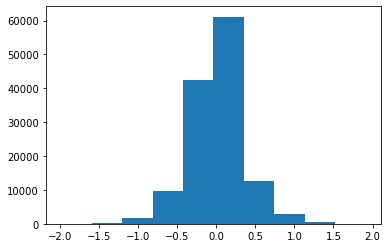

In [45]:
#Finding bin edges on full 1 year training data (Not possible for 40 years)
args['is_categorical']=False
dg_train, dg_valid, dg_test = load_data(**args)
args['is_categorical']=True

x,y=dg_train[0]; print(x.shape, y.shape)
diff=y-x[...,dg_train.output_idxs]
print(diff.min(), diff.max(), diff.mean())
plt.hist(diff.reshape(-1))

In [46]:
diff=[]
for x,y in dg_train:
    diff.append(y-x[...,dg_train.output_idxs])
diff = np.array([ elem for singleList in diff for elem in singleList])
diff.shape

(4342, 32, 64, 2)

In [47]:
diff_shape=diff.shape
diff2, bins=pd.qcut(diff.reshape(-1), args['num_bins'], 
                    labels=False, retbins=True)

In [48]:
bins

array([-2.73163891, -0.79235148, -0.63346175, -0.53464085, -0.46216282,
       -0.4034267 , -0.3540867 , -0.31212731, -0.27473986, -0.24185574,
       -0.21199325, -0.18581751, -0.16180843, -0.13989019, -0.12109613,
       -0.10439277, -0.08977759, -0.0764758 , -0.06473017, -0.05428517,
       -0.04453588, -0.03511643, -0.02609849, -0.01708186, -0.00835168,
        0.        ,  0.00835168,  0.01670468,  0.02586043,  0.03445137,
        0.04384542,  0.05395961,  0.06472263,  0.07620728,  0.08892012,
        0.10376647,  0.12068489,  0.13988018,  0.16105443,  0.18478024,
        0.21152642,  0.2411474 ,  0.27351201,  0.3103444 ,  0.35250961,
        0.40191245,  0.46072417,  0.53528172,  0.63679653,  0.79860985,
        2.62723827])

In [49]:
args['is_doi']=True
args['bin_min']=bins[0]; args['bin_max']=bins[-1]
args['adaptive_bins']=bins
args['num_bins'], args['bin_min'], args['bin_max']

(50, -2.7316389083862305, 2.6272382736206055)

In [34]:
#args

In [50]:
dg_train, dg_valid, dg_test = load_data(**args)

In [51]:
x,y=dg_train[0]; print(x.shape, y.shape)
x,y=dg_valid[0]; print(x.shape, y.shape) 
x,y=dg_test[0]; print(x.shape, y.shape)
#changing valid shape too. maybe not a good idea.

(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)


In [52]:
y.min(), y.max(), y[0,0,0,0,:]

(0.0,
 1.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [53]:
x[0,0,0,0]

-0.7531484

(array([  430.,  4997.,  8783.,  5735.,  5599.,  4586.,  3299.,  3959.,
         7300., 20848.]),
 array([ 7., 10., 13., 16., 19., 22., 25., 28., 31., 34., 37.]),
 <a list of 10 Patch objects>)

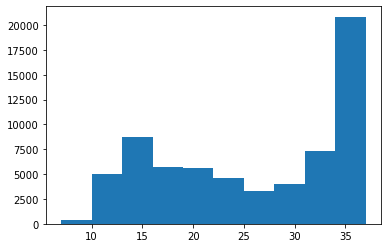

In [54]:
#checking if data generator worked
idxs = np.argmax(y, -1)
plt.hist(idxs[...,0].reshape(-1))

In [70]:
# #compare distribution to non-adaptive.
# args['bins']=None; args['bin_min']=-2; args['bin_max']=2
# dg_train, dg_valid, dg_test = load_data(**args)
# x,y=dg_test[0]; print(x.shape, y.shape)
# #remember y is not same bcoz of shuffle in train. so use test.

(32, 32, 64, 114) (32, 32, 64, 2, 50)


In [71]:
x[0,0,0,0]

-0.7531484

(array([  351.,  4511.,  8803.,  5853.,  5599.,  4682.,  3308.,  3822.,
         6743., 21864.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

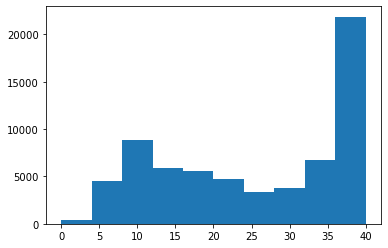

In [72]:
idxs = np.argmax(y, -1)
plt.hist(idxs[...,0].reshape(-1))

In [ ]:
#so different distributions with adaptive/non-adaptive.

# Training for adaptive bins

In [21]:
# model2 = build_resnet_categorical(
#     **args, input_shape=dg_train.shape,
# )
# # model.summary()

# categorical_loss = create_lat_categorical_loss(dg_train.data.lat, 2)
# model2.compile(keras.optimizers.Adam(1e-3), loss=categorical_loss)


# model_history=model2.fit(dg_train, epochs=50)

Epoch 1/50
136/136 [==============================] - 49s 361ms/step - loss: 6.5560
Epoch 2/50
136/136 [==============================] - 50s 367ms/step - loss: 4.6104
Epoch 3/50
136/136 [==============================] - 51s 376ms/step - loss: 4.3396
Epoch 4/50
136/136 [==============================] - 51s 374ms/step - loss: 4.1535
Epoch 5/50
136/136 [==============================] - 51s 373ms/step - loss: 4.1815
Epoch 6/50
136/136 [==============================] - 51s 374ms/step - loss: 4.0734
Epoch 7/50
136/136 [==============================] - 51s 372ms/step - loss: 3.8996
Epoch 8/50
136/136 [==============================] - 51s 373ms/step - loss: 3.7947
Epoch 9/50
136/136 [==============================] - 51s 376ms/step - loss: 3.7118
Epoch 10/50
136/136 [==============================] - 51s 376ms/step - loss: 3.5961
Epoch 11/50
136/136 [==============================] - 50s 371ms/step - loss: 3.5001
Epoch 12/50
136/136 [==============================] - 51s 378ms/step - lo

In [22]:
# exp_id='categorical_doi_adaptive_bins_v1'
# model_save_dir=args['model_save_dir']

# model2.save(f'{model_save_dir}/{exp_id}.h5')
# model2.save_weights(f'{model_save_dir}/{exp_id}_weights.h5')

# to_pickle(model_history.history, f'{model_save_dir}/{exp_id}_history.pkl')

In [38]:
# checking training

In [39]:
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Predictions for Adaptive bins

In [55]:
exp_id='categorical_doi_adaptive_bins_v1'
model_save_dir=args['model_save_dir']
model2 = keras.models.load_model(
    f'{model_save_dir}/{exp_id}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'categorical_loss': keras.losses.mse}
)

In [57]:
#args

In [58]:
#full-data (apr-dec 2018)
preds = create_predictions(model2, dg_test, is_categorical=True, is_doi=True,
                           bin_min=args['bin_min'], bin_max=args['bin_max'],
                          adaptive_bins=bins)
preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 3262)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 2.552299e-15 ... 1.3318208e-13
    t        (time, lat, lon, bin) float32 0.027164053 ... 1.59837e-13

In [59]:
#extremely small values may increase numerical error? (x-y)
preds.t.min(), preds.t.max(), preds.t.mean()

(<xarray.DataArray 't' ()>
 array(0.),
 <xarray.DataArray 't' ()>
 array(0.99950755),
 <xarray.DataArray 't' ()>
 array(0.02000005, dtype=float32))

In [60]:
preds.t.bin_edges
#surprisingly end points are much larger than with non-adaptive. will Check!!

array([-39.28567329, -11.39537933,  -9.11027126,  -7.68905643,
        -6.64669755,  -5.80197094,  -5.09237669,  -4.48892845,
        -3.9512325 ,  -3.47830219,  -3.0488281 ,  -2.6723759 ,
        -2.32708399,  -2.01186198,  -1.74157102,  -1.50134783,
        -1.29115639,  -1.09985374,  -0.93093132,  -0.78071424,
        -0.64050261,  -0.50503482,  -0.37534124,  -0.24566653,
        -0.1201116 ,   0.        ,   0.1201116 ,   0.24024205,
         0.37191752,   0.49546998,   0.6305726 ,   0.77603212,
         0.93082288,   1.09599197,   1.27882446,   1.49234061,
         1.73565665,   2.01171797,   2.31624008,   2.65745817,
         3.04211437,   3.46811502,   3.93357382,   4.46328707,
         5.0696954 ,   5.78019342,   6.62600733,   7.69827323,
         9.15823117,  11.48538545,  37.78421232])

# Most likely class

In [61]:
# Using bin_mid_points of prediction with highest probability
das = []
for var in ['z', 't']:
    idxs = np.argmax(preds[var], -1)
    most_likely = preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [preds.time, preds.lat, preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)

preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3262)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 -624.0 -711.9 -810.3 ... -473.2 -473.2
    t        (time, lat, lon) float64 -8.4 -8.4 -8.4 ... -2.861 -2.861 -2.861

In [62]:
datadir=args['datadir']
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [63]:
preds_ml_new=preds_ml+valid.shift(time=-dg_test.lead_time)

In [64]:
#be careful of last points (2018-12-28) to 2018-12-31. 
#they must contain nan values
preds_ml_new.t.isel(time=-36).values
#preds_new.t.sel(time='2018-12-28T22:00:00').values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [65]:
#removing last 3 days (naive approach)
preds_ml_new=preds_ml_new.sel(time=slice(None,'2018-12-28T22:00:00'))

In [66]:
preds_ml_new.t.max().values, preds_ml_new.t.min().values, preds_ml_new.t.mean().values
#edges are more extreme!

(array(326.401492), array(193.76303509), array(275.31431088))

In [67]:
valid.t.max().values, valid.t.min().values, valid.t.mean().values

(array(311.45795, dtype=float32),
 array(218.9723, dtype=float32),
 array(275.03195, dtype=float32))

# RMSE

In [68]:
compute_weighted_rmse(preds_ml_new, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 972.6
    t_rmse   float64 4.674

In [ ]:
#almost same as non-adaptive. loss comparable (~2.9 for no-adaptive. ~2.3 for adaptive)

# Binned CRPS

In [69]:
preds['t'].mid_points

array([-25.34052631, -10.25282529,  -8.39966384,  -7.16787699,
        -6.22433425,  -5.44717381,  -4.79065257,  -4.22008047,
        -3.71476735,  -3.26356515,  -2.860602  ,  -2.49972994,
        -2.16947298,  -1.8767165 ,  -1.62145942,  -1.39625211,
        -1.19550506,  -1.01539253,  -0.85582278,  -0.71060843,
        -0.57276871,  -0.44018803,  -0.31050388,  -0.18288906,
        -0.0600558 ,   0.0600558 ,   0.18017683,   0.30607979,
         0.43369375,   0.56302129,   0.70330236,   0.8534275 ,
         1.01340743,   1.18740821,   1.38558254,   1.61399863,
         1.87368731,   2.16397902,   2.48684913,   2.84978627,
         3.2551147 ,   3.70084442,   4.19843045,   4.76649124,
         5.42494441,   6.20310037,   7.16214028,   8.4282522 ,
        10.32180831,  24.63479888])

In [70]:
#changing Observation directly instead of predictions for binned crps
obs=valid-valid.shift(time=-dg_test.lead_time)
obs=obs.sel(time=preds.time) #reducing to preds size
obs=obs.sel(time=slice(None,'2018-12-28T22:00:00'))#removing nan values


In [71]:
print(
valid.t.isel(lat=0,lon=0).sel(time='2018-05-05T22:00:00').values,
valid_x_new.t.isel(lat=0,lon=0).sel(time='2018-05-05T22:00:00').values,
obs.t.isel(lat=0,lon=0).sel(time='2018-05-05T22:00:00').values
)

240.97852 246.35167 -5.3731537


In [72]:
obs #reduced set. 2018-01-04 to 2018-12-28

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3226)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-28T22:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(3226, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(3226, 32, 64), meta=np.ndarray>

In [73]:
obs1 = obs.sel(time='2018-05-05')
preds1 = preds.sel(time='2018-05-05')

In [74]:
compute_weighted_bin_crps(preds1, obs1).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 1.595e+04
    t        float64 72.55

In [ ]:
#pretty bad again.

# comparing to - without input difference

In [77]:
from src.data_generator import *

In [88]:
args['bin_min']=-5; args['bin_max']=5 #checked min, max of (x-y) in train.
args['num_bins'], args['bin_min'], args['bin_max']
dg_train, dg_valid, dg_test = load_data(**args)

In [89]:
x,y=dg_train[0]; print(x.shape, y.shape)
x,y=dg_valid[0]; print(x.shape, y.shape) 
x,y=dg_test[0]; print(x.shape, y.shape)

(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)
(32, 32, 64, 114) (32, 32, 64, 2, 50)


In [90]:
y[0,0,0,0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [91]:
args['bin_min']

-5

In [92]:
model = build_resnet_categorical(
    **args, input_shape=dg_train.shape,
)
# model.summary()

In [93]:
categorical_loss = create_lat_categorical_loss(dg_train.data.lat, 2)
model.compile(keras.optimizers.Adam(1e-3), loss=categorical_loss)


In [94]:
model.fit(dg_train, epochs=30)

Epoch 1/30
136/136 [==============================] - 48s 355ms/step - loss: 5.3799
Epoch 2/30
136/136 [==============================] - 50s 369ms/step - loss: 3.4690
Epoch 3/30
136/136 [==============================] - 51s 377ms/step - loss: 3.2071
Epoch 4/30
136/136 [==============================] - 51s 373ms/step - loss: 3.1679
Epoch 5/30
136/136 [==============================] - 51s 377ms/step - loss: 3.0492
Epoch 6/30
136/136 [==============================] - 51s 378ms/step - loss: 2.9614
Epoch 7/30
136/136 [==============================] - 51s 377ms/step - loss: 2.9988
Epoch 8/30
136/136 [==============================] - 51s 373ms/step - loss: 2.8479
Epoch 9/30
136/136 [==============================] - 51s 376ms/step - loss: 2.7417
Epoch 10/30
136/136 [==============================] - 51s 373ms/step - loss: 2.6448
Epoch 11/30
136/136 [==============================] - 51s 377ms/step - loss: 2.6447
Epoch 12/30
136/136 [==============================] - 51s 376ms/step - lo

In [ ]:
#Much faster training.

In [ ]:
#small test

In [95]:
xtrue ,ytrue=dg_valid[0]
ypred=model.predict(xtrue)

In [96]:
ytrue.shape, ytrue.max(),ytrue.min(), ytrue.mean()

((32, 32, 64, 2, 50), 1.0, 0.0, 0.02)

In [97]:
ypred.shape, ypred.max(),ypred.min(), ypred.mean()

((32, 32, 64, 2, 50), 0.9999192, 0.0, 0.02)

In [ ]:
#apr-dec

In [98]:
preds = create_predictions(model, dg_test, is_categorical=True)

In [99]:
preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 3262)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 7.695482e-07 ... 8.68365e-11
    t        (time, lat, lon, bin) float32 1.3076001e-07 ... 9.324457e-10

In [100]:
preds.t.min(), preds.t.max(), preds.t.mean()

(<xarray.DataArray 't' ()>
 array(0.),
 <xarray.DataArray 't' ()>
 array(0.99868566),
 <xarray.DataArray 't' ()>
 array(0.02, dtype=float32))

In [ ]:
idxs = np.argmax(preds.t.isel(time=0), -1)

In [ ]:
mp = preds.t.mid_points

In [ ]:
# Most likely bin
plt.matshow(mp[idxs])
plt.colorbar();

In [101]:
# Let's do this for all times and compute the RMSE
das = []
for var in ['z', 't']:
    idxs = np.argmax(preds[var], -1)
    most_likely = preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [preds.time, preds.lat, preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)

In [102]:
preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3262)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 4.809e+04 4.809e+04 ... 4.997e+04
    t        (time, lat, lon) float64 240.9 240.9 240.9 ... 252.4 252.4 255.3

In [103]:
datadir=args['datadir']
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [104]:
valid=valid.sel(time=preds_ml.time)

In [105]:
compute_weighted_rmse(preds_ml, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 681.3
    t_rmse   float64 3.279

In [3]:
preds.t.bin_width / 2

NameError: name 'preds' is not defined

In [ ]:
preds.t.isel(time=0).max('bin').plot()

In [ ]:
plt.bar(preds.t.mid_points, preds.t.isel(time=0).sel(lat=50, lon=300, method='nearest'), preds.t.bin_width)
plt.bar(preds.t.mid_points, preds.t.isel(time=0).sel(lat=0, lon=150, method='nearest'), preds.t.bin_width)

In [ ]:
plt.bar(preds.t.mid_points, preds.t.isel(time=0).sel(lat=50, lon=20, method='nearest'), preds.t.bin_width)
plt.bar(preds.t.mid_points, preds.t.isel(time=0).sel(lat=0, lon=0, method='nearest'), preds.t.bin_width)

## Binned CRPS

In [106]:
def compute_bin_crps(obs, preds, bin_edges):
    """
    Last axis must be bin axis
    obs: [...]
    preds: [..., n_bins]
    """
    obs = obs.values
    preds = preds.values
    # Convert observation
    a = np.minimum(bin_edges[1:], obs[..., None])
    b = bin_edges[:-1] * (bin_edges[0:-1] > obs[..., None])
    y = np.maximum(a, b)
    # Convert predictions to cumulative predictions with a zero at the beginning
    cum_preds = np.cumsum(preds, -1)
    cum_preds_zero = np.concatenate([np.zeros((*cum_preds.shape[:-1], 1)), cum_preds], -1)
    xmin = bin_edges[..., :-1]
    xmax = bin_edges[..., 1:]
    lmass = cum_preds_zero[..., :-1]
    umass = 1 - cum_preds_zero[..., 1:]
#     y = np.atleast_1d(y)
#     xmin, xmax = np.atleast_1d(xmin), np.atleast_1d(xmax)
#     lmass, lmass = np.atleast_1d(lmass), np.atleast_1d(lmass)
    scale = xmax - xmin
#     print('scale =', scale)
    y_scale = (y - xmin) / scale
#     print('y_scale = ', y_scale)
    
    z = y_scale.copy()
    z[z < 0] = 0
    z[z > 1] = 1
#     print('z =', z)
    a = 1 - (lmass + umass)
#     print('a =', a)
    crps = (
        np.abs(y_scale - z) + z**2 * a - z * (1 - 2*lmass) + 
        a**2 / 3 + (1 - lmass) * umass
    )
    return np.sum(scale * crps, -1)

In [107]:
def compute_weighted_bin_crps(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    """
    t = np.intersect1d(da_fc.time, da_true.time)
    da_fc, da_true = da_fc.sel(time=t), da_true.sel(time=t)
    weights_lat = np.cos(np.deg2rad(da_true.lat))
    weights_lat /= weights_lat.mean()
    dims = ['time', 'lat', 'lon']
    if type(da_true) is xr.Dataset:
        das = []
        for var in da_true:
            result = compute_bin_crps(da_true[var], da_fc[var], da_fc[var].bin_edges)
            das.append(xr.DataArray(
                result, dims=dims, coords=dict(da_true.coords), name=var
            ))
        crps = xr.merge(das)
    else:
        result = compute_bin_crps(da_true, da_fc, da_fc.bin_edges)
        crps = xr.DataArray(
            result, dims=dims, coords=dict(da_true.coords), name=da_fc.name
        )
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

In [1]:
valid

NameError: name 'valid' is not defined

In [2]:
compute_weighted_bin_crps(preds, valid)

NameError: name 'compute_weighted_bin_crps' is not defined

In [ ]:
# Ignore below

# Adaptive binning

In [ ]:
args['is_categorical']=False
dg_train, dg_valid, dg_test = load_data(**args)
args['is_categorical']=True
x,y=dg_train[0]; print(x.shape, y.shape)

diff=y-x[...,dg_train.output_idxs]

print(diff.min(), diff.max(), diff.mean())

plt.hist(diff.reshape(-1))

In [232]:
diff=[]
for x,y in dg_train:
    diff.append(y-x[...,dg_train.output_idxs])

In [233]:
diff = np.array([ elem for singleList in diff for elem in singleList])

In [234]:
diff.shape

(4342, 32, 64, 2)

In [254]:
diff_shape=diff.shape
diff2, bins=pd.qcut(diff.reshape(-1), args['num_bins'], 
                    labels=False, retbins=True)

In [255]:
diff2=diff2.reshape(diff_shape)

In [256]:
diff2.shape, diff2.max(), diff2.min(), diff2.mean()

((4342, 32, 64, 2), 49, 0, 24.497140709566445)

In [257]:
bins

array([-2.73163891, -0.79235148, -0.63346175, -0.53464085, -0.46216282,
       -0.4034267 , -0.3540867 , -0.31212731, -0.27473986, -0.24185574,
       -0.21199325, -0.18581751, -0.16180843, -0.13989019, -0.12109613,
       -0.10439277, -0.08977759, -0.0764758 , -0.06473017, -0.05428517,
       -0.04453588, -0.03511643, -0.02609849, -0.01708186, -0.00835168,
        0.        ,  0.00835168,  0.01670468,  0.02586043,  0.03445137,
        0.04384542,  0.05395961,  0.06472263,  0.07620728,  0.08892012,
        0.10376647,  0.12068489,  0.13988018,  0.16105443,  0.18478024,
        0.21152642,  0.2411474 ,  0.27351201,  0.3103444 ,  0.35250961,
        0.40191245,  0.46072417,  0.53528172,  0.63679653,  0.79860985,
        2.62723827])

In [258]:
diff2=np_utils.to_categorical(diff2, num_classes=args['num_bins'])

In [259]:
diff2.shape, diff2.max(), diff2.min(), diff2.mean()

((4342, 32, 64, 2, 50), 1.0, 0.0, 0.020001106)

In [260]:
diff3=diff
diff3_shape=diff3.shape
diff3.shape

(4342, 32, 64, 2)

In [261]:
diff3=pd.cut(diff3.reshape(-1), bins, labels=False).reshape(diff3_shape)

In [262]:
diff3.shape

(4342, 32, 64, 2)

In [263]:
diff3

array([[[[12.,  2.],
         [12.,  1.],
         [12.,  1.],
         ...,
         [11.,  3.],
         [12.,  2.],
         [12.,  2.]],

        [[38., 48.],
         [38., 47.],
         [37., 46.],
         ...,
         [26., 49.],
         [32., 49.],
         [36., 49.]],

        [[46., 46.],
         [44., 43.],
         [40., 34.],
         ...,
         [37., 46.],
         [42., 45.],
         [45., 48.]],

        ...,

        [[46., 45.],
         [47., 45.],
         [47., 43.],
         ...,
         [38., 42.],
         [42., 41.],
         [45., 43.]],

        [[42., 40.],
         [41., 35.],
         [39., 23.],
         ...,
         [44., 47.],
         [44., 46.],
         [43., 43.]],

        [[48., 48.],
         [48., 48.],
         [48., 48.],
         ...,
         [48., 49.],
         [48., 49.],
         [48., 48.]]],


       [[[ 6.,  4.],
         [ 6.,  3.],
         [ 7.,  2.],
         ...,
         [ 5.,  7.],
         [ 5.,  6.],
         [ 6.

In [264]:
diff3.shape, diff3.max(), diff3.min(), diff3.mean()

((4342, 32, 64, 2), nan, nan, nan)

In [271]:
diff3[:,:,:,1].min()

nan

In [273]:
np.argwhere(np.isnan(diff3))

array([[1743,   25,   49,    1]])

In [278]:
diff[1743,25,49,1]

-2.731639

# Unnormalized Data

In [ ]:
a1=np.arange(100)
mean=np.mean(a1); std=np.std(a1)

In [ ]:
a1_norm=(a1-mean)/std

In [ ]:
a1_norm

In [ ]:
a1[4]-a1[2]

In [ ]:
diff=a1_norm[4]-a1_norm[2]
diff

In [ ]:
diff*std